# исследование применения методов машинного обучения в астрономии и построение расширенной диаграммы Герцшпрунга-Рассела
проект выполнен ученицей 8 класса Чумасовой Полиной

Известно, что для решения астрономических задач всегда необходимы данные. Мы часто сталкиваемся с тем, что   необходимое количество данных недоступно, за этим следует то, что задача становится нерешаемой, но с помощью методов машинного обучения, которые применены в данном проекте, количество аналогичных ситуаций можно свести к минимуму. Идеальным решением этой проблемы было бы построение диаграммы, имеющей все параметры, которые могут понадобиться. Как фундамент для нее, была взята диаграмма Герцшпрунга-Рассела, в которой можно наблюдать такие параметры как абсолютная звездная величина (в дальнейшем для удобства будет использована аббревиатура АЗВ), светимость, температура, возраст звезд и так далее. При анализе этой диаграммы было принято решение добавить параметр расстояния звезд до земли. 

In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn.datasets import make_regression
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KDTree
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error


import warnings
warnings.filterwarnings("ignore")

In [3]:
stefconst = 5.67 * 10**-8
pi = 3.14
Rro = 2.26*10**-8

In [ ]:
в открытом источнике я нашла два набора данных, в одном были такие параметры как температура, освещенность, радиус, АЗВ, класс и цвет звезды, а в другом видимая звездная величина, параллакс, класс и АЗВ.
Загрузим их и предобработаем

<Axes: >

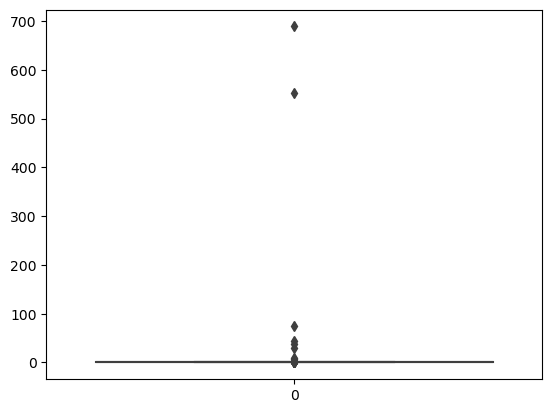

In [4]:
df = pd.read_csv(r"6 class csv.csv")
test1df = pd.read_csv(r"6 class csv.csv")
df2 = pd.read_csv(r"paralaxo.csv")

df.drop(["Star color", "Spectral Class"], axis=1, inplace=True)
df2.drop(['SpType'],axis = 1, inplace=True)

df = df[df['Absolute magnitude(Mv)'] > 0]
sns.boxplot(df['Luminosity(L/Lo)'])

первый набор данных содержит в себе все необходимые для диаграммы переменные, следует создать ее и проверить, увидим ли мы главную последовательность

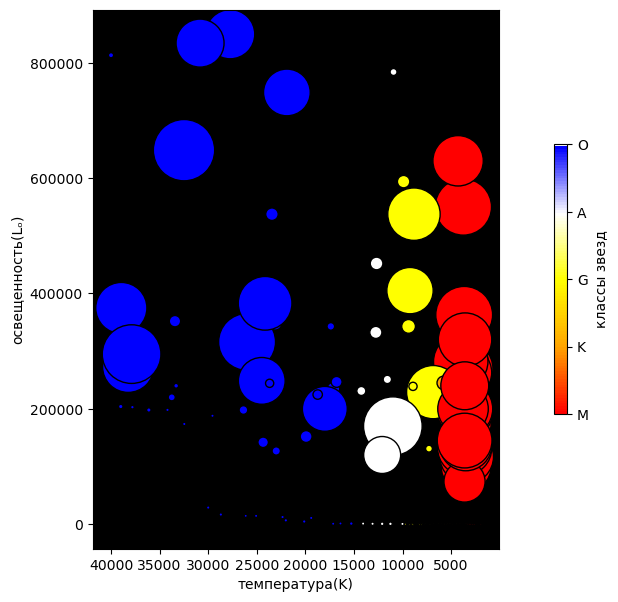

In [5]:
luminosity = test1df['Luminosity(L/Lo)']
temperature = test1df['Temperature (K)']
radius = test1df['Radius(R/Ro)']

fig2 = plt.figure(figsize=(7,7))
ax2 = fig2.add_subplot()

yP = luminosity
xP = temperature
size = radius

everycolor = []
for j in range(len(temperature)):
    if temperature[j] <= 4500 :
        everycolor.append(("#ff0000"))
    if temperature[j] >= 4501 and temperature[j] <= 6000:
        everycolor.append(("#ffa500"))
    if temperature[j] >= 6001 and temperature[j] <= 10000:
        everycolor.append(("#ffff00"))
    if temperature[j] >= 10001 and temperature[j] <= 15000:
        everycolor.append(("#ffffff"))
    if temperature[j] >= 15001:
        everycolor.append(("#0000ff"))

colors = ['red','orange','yellow','white', 'blue']
n_bins = 100
cmap_name = 'starClasses'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N= n_bins)

ax2.scatter(xP,yP,sizes = size, c = everycolor, marker = 'o',edgecolor = 'black', s = 100)

ax2.set_xlabel("температура(K)")
ax2.set_ylabel("освещенность(Lₒ)")
plt.gca().invert_xaxis()


Z = [i for i in range(160)]
sm = ScalarMappable(cmap= cm, norm=Normalize(vmin=np.min(Z), vmax=np.max(Z)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, pad=0.1, shrink = 0.5)
ax2.set_facecolor(color="black")
cbar.set_ticks([0,40,80,120,160])
cbar.set_ticklabels(['M','K','G','A','O'])

cbar.set_label('классы звезд')
plt.show()

главная последовательность не наблюдается, так как в наборе содержатся "анонимные" звезды, в отличие от оригинала, в котором находится 22 тысяч звёзд из каталога Hipparcos и около 1000 близких звёзд из каталога Глизе

так как у нас 2 набора данных с одной и той же переменной (АЗВ), мы можем выдвинуть гипотезу, что если соединить в пары максимально схожие значения АЗВ из двух столбцов, то и другие значения будут похожи, и если это так, то соединить наши датасеты, первой идеей как это сделать была более "ручная" версия, но из-за низкой корреляции и сильного сокращения количества данных принято решение использовать алгоритм KDTree

In [6]:
tree = KDTree(df["Absolute magnitude(Mv)"].values.reshape((-1, 1)), leaf_size=3)
dist, ind = tree.query(df2["Amag"].values.reshape((-1, 1)), k=3)
mean_features = [df.iloc[idxes].mean(axis=0) for idxes in ind]
mean_features
df = pd.DataFrame(mean_features)
df.drop(['Star type'], axis = 1,inplace = True)
dfm  = pd.concat([df2,df],axis = 1)

далее расчитаем расстояние по двум выведенным формулам, также переведем все в радиусы солнца и посмотрим зависимость переменных, чтобы сделать выводы о достоверности формул

In [21]:
m = np.array(dfm['Vmag'])
M = np.array(dfm['Amag'])
r = np.array(dfm['Radius(R/Ro)'])
t = np.array(dfm['Temperature (K)'])

distance1 = 10 * 10**((m - M)/5)
distance1

F = 10**(-0.4*(m-M))
distance2 = ((r**2 * stefconst * t**4)/F)**0.5
distance1 = Rro * distance1
dfm["dist1"] = distance1
dfm["dist2"] = distance2

In [8]:
corr = abs(dfm.corr())
corr.style.background_gradient(cmap='coolwarm')

,Vmag,Plx,e_Plx,B-V,Amag,TargetClass,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),dist1,dist2
Vmag,1.000000,0.191414,0.557063,0.046950,0.287126,0.128945,0.196061,0.026745,0.112961,0.284049,0.128052,0.045755
Plx,0.191414,1.000000,0.062239,0.074046,0.635550,0.348977,0.354138,0.085998,0.225950,0.604719,0.263955,0.156909
e_Plx,0.557063,0.062239,1.000000,0.053166,0.260421,0.102710,0.150619,0.020523,0.091803,0.248797,0.055983,0.018725
B-V,0.046950,0.074046,0.053166,1.000000,0.073903,0.554469,0.078831,0.010179,0.043722,0.089820,0.052674,0.036435
Amag,0.287126,0.635550,0.260421,0.073903,1.000000,0.442479,0.664059,0.271669,0.433444,0.985104,0.523672,0.412249
TargetClass,0.128945,0.348977,0.102710,0.554469,0.442479,1.000000,0.280207,0.067565,0.184470,0.444541,0.154972,0.106062
Temperature (K),0.196061,0.354138,0.150619,0.078831,0.664059,0.280207,1.000000,0.059151,0.014395,0.696837,0.330377,0.307071
Luminosity(L/Lo),0.026745,0.085998,0.020523,0.010179,0.271669,0.067565,0.059151,1.000000,0.418548,0.302322,0.679467,0.621961
Radius(R/Ro),0.112961,0.225950,0.091803,0.043722,0.433444,0.184470,0.014395,0.418548,1.000000,0.448377,0.415716,0.343176
Absolute magnitude(Mv),0.284049,0.604719,0.248797,0.089820,0.985104,0.444541,0.696837,0.302322,0.448377,1.000000,0.540248,0.419883


подобная корреляция сообщает о том, что наборы соеденены верно, так как можно найти определенный линейный коэффициент для равенства. Также можно сказать, что формулы достоверно работают

так как был использован алгоритм KDTree, мы пожертвовали тем прежним размахом светимости, построим графики, чтобы увидеть распределение и представление о переменной

<Axes: xlabel='Luminosity(L/Lo)', ylabel='Count'>

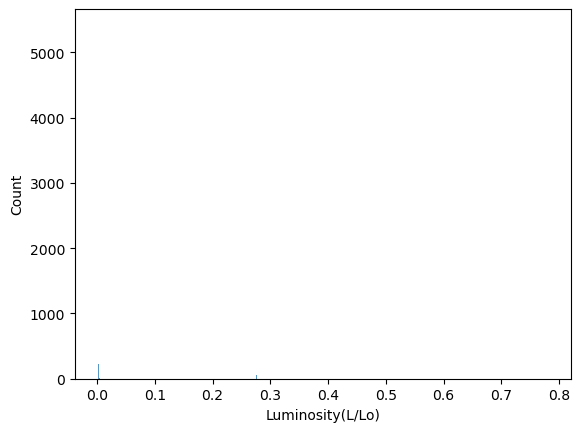

In [9]:
dfm['Luminosity(L/Lo)'].mean()
sns.histplot(dfm['Luminosity(L/Lo)'])

<Axes: >

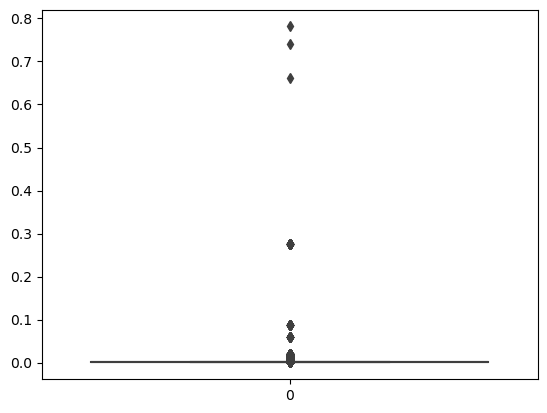

In [10]:
sns.boxplot(dfm['Luminosity(L/Lo)'])

In [11]:
dfm = dfm.drop(['Absolute magnitude(Mv)'], axis = 1)

теперь применим 5 алгоритмов машинного обучения для каждой целевой переменной и выберем лучшую путем сравнения

### 1.градиентный бустинг

In [12]:
y_co = ["Luminosity(L/Lo)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_co, axis=1), dfm[y_co], test_size=0.2, random_state=42)

est = GradientBoostingRegressor(n_estimators=100, learning_rate=1.3, max_depth=1,
                                random_state=0, loss='squared_error').fit(X_train, y_train)

Luminosity_gradient =  [est.predict(X_test), est.score(X_test, y_test).round(3)]
Luminosity_gradient_MAPE = (mean_absolute_percentage_error(y_test, est.predict(X_test))*100).round(2)

print("точность алгоритма для значений светимости:",Luminosity_gradient[1])
print("MAPE светимости:", Luminosity_gradient_MAPE, "%")

y_cols = ["Temperature (K)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_cols, axis=1), dfm[y_cols], test_size=0.2)
est.fit(X_train, y_train)

temperature_gradient = [est.predict(X_test), est.score(X_test, y_test).round(3)]
temperature_gradient_MAPE = (mean_absolute_percentage_error(y_test, est.predict(X_test))*100).round(2)

print("точность алгоритма для значений температуры:",temperature_gradient[1])
print("MAPE температуры:",temperature_gradient_MAPE, "%")


y_c = ['dist2']
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_c, axis=1), dfm[y_c], test_size=0.2,random_state=42)
est.fit(X_train, y_train)

distance_Gradient =  [est.predict(X_test), est.score(X_test, y_test).round(3)]
distance_gradient_MAPE = (mean_absolute_percentage_error(y_test, est.predict(X_test))*100).round(2)

print("точность алгоритма для значений расстояния:",distance_Gradient[1])
print("MAPE расстояния:",distance_gradient_MAPE, "%")

точность алгоритма для значений светимости: 0.999
MAPE светимости: 18.62 %
точность алгоритма для значений температуры: 0.982
MAPE температуры: 3.91 %
точность алгоритма для значений расстояния: 0.778
MAPE расстояния: 2644.62 %


### 2. K-ближайших соседей

In [13]:
y_co = ["Luminosity(L/Lo)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_co, axis=1), dfm[y_co], test_size=0.2, random_state=42)

Knn = KNeighborsRegressor(n_neighbors=3)
Knn = Knn.fit(X_train, y_train)

Luminosity_knn = [Knn.predict(X_test),Knn.score(X_test, y_test).round(3)]
Luminosity_knn_MAPE = (mean_absolute_percentage_error(y_test, Knn.predict(X_test))*100).round(2)

print("точность алгоритма для значений светимости:",Luminosity_knn[1])
print("MAPE светимости:", Luminosity_knn_MAPE, "%")

y_cols = ["Temperature (K)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_cols, axis=1), dfm[y_cols], test_size=0.2)
Knn = Knn.fit(X_train, y_train)

Temperature_knn = [Knn.predict(X_test), Knn.score(X_test, y_test).round(3)]
temperature_knn_MAPE = (mean_absolute_percentage_error(y_test, Knn.predict(X_test))*100).round(2)

print("точность алгоритма для значений температуры:",Temperature_knn[1])
print("MAPE температуры:",temperature_knn_MAPE, "%")


y_c = ['dist2']
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_c, axis=1), dfm[y_c], test_size=0.2,random_state=42)

Knn = Knn.fit(X_train, y_train)

distance_Knn =  [Knn.predict(X_test), Knn.score(X_test, y_test).round(3)]
distance_knn_MAPE = (mean_absolute_percentage_error(y_test, Knn.predict(X_test))*100).round(2)

print("точность алгоритма для значений расстояния:",distance_Knn[1])
print("MAPE расстояния:",distance_knn_MAPE, "%")

точность алгоритма для значений светимости: 0.991
MAPE светимости: 2.78 %
точность алгоритма для значений температуры: 0.644
MAPE температуры: 10.37 %
точность алгоритма для значений расстояния: 0.968
MAPE расстояния: 11.97 %


### 3. Дерево решений

In [14]:
y_co = ["Luminosity(L/Lo)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_co, axis=1), dfm[y_co], test_size=0.2, random_state=42)

dtree = DecisionTreeRegressor()
dtree = dtree.fit(X_train, y_train)

Luminosity_DecisionTree = [dtree.predict(X_test), dtree.score(X_test, y_test).round(3)]
luminosity_dtree_MAPE = (mean_absolute_percentage_error(y_test, dtree.predict(X_test))*100).round(2)

print("точность алгоритма для значений светимости:",Luminosity_DecisionTree[1])
print("MAPE светимости:", luminosity_dtree_MAPE, "%")

y_cols = ["Temperature (K)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_cols, axis=1), dfm[y_cols], test_size=0.2)

dtree = dtree.fit(X_train, y_train)

temperature_dtree_MAPE = (mean_absolute_percentage_error(y_test, dtree.predict(X_test))*100).round(2)
Temperature_DecisionTree = [dtree.predict(X_test), dtree.score(X_test, y_test).round(3)]

print("точность алгоритма для значений температуры:",Temperature_DecisionTree[1])
print("MAPE температуры:",temperature_dtree_MAPE, "%")


y_c = ['dist2']
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_c, axis=1), dfm[y_c], test_size=0.2,random_state=42)

dtree = dtree.fit(X_train, y_train)

distance_dtree_MAPE = (mean_absolute_percentage_error(y_test, dtree.predict(X_test))*100).round(2)
distance_DecisionTree =  [dtree.predict(X_test), dtree.score(X_test, y_test).round(3)]

print("точность алгоритма для значений расстояния:",distance_DecisionTree[1])
print("MAPE расстояния:",distance_dtree_MAPE, "%")

точность алгоритма для значений светимости: 1.0
MAPE светимости: 0.0 %
точность алгоритма для значений температуры: 1.0
MAPE температуры: 0.01 %
точность алгоритма для значений расстояния: 0.959
MAPE расстояния: 4.06 %


### 4. Рандомный лес

In [15]:
y_co = ["Luminosity(L/Lo)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_co, axis=1), dfm[y_co], test_size=0.2, random_state=42)

Forest = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
Forest.fit(X_train, y_train)

Luminosity_RandomForest = [Forest.predict(X_test), Forest.score(X_test, y_test).round(3)]
Luminosity_forest_MAPE = (mean_absolute_percentage_error(y_test, Forest.predict(X_test))*100).round(2)

print("точность алгоритма для значений светимости:", Luminosity_RandomForest[1])
print("MAPE светимости:", Luminosity_forest_MAPE, "%")


y_cols = ["Temperature (K)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_cols, axis=1), dfm[y_cols], test_size=0.2)

Forest.fit(X_train, y_train)

Temperature_RandomForest = [Forest.predict(X_test), Forest.score(X_test, y_test).round(3)]
temperature_forest_MAPE = (mean_absolute_percentage_error(y_test, Forest.predict(X_test))*100).round(2)

print("точность алгоритма для значений температуры:", Temperature_RandomForest[1])
print("MAPE температуры:",temperature_forest_MAPE, "%")


y_c = ['dist2']
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_c, axis=1), dfm[y_c], test_size=0.2,random_state=42)
Forest.fit(X_train, y_train)

distance_RandomForest = [Forest.predict(X_test), Forest.score(X_test, y_test).round(3)]
distance_forest_MAPE = (mean_absolute_percentage_error(y_test, Forest.predict(X_test))*100).round(2)

print("точность алгоритма для значений расстояния:", distance_RandomForest[1])
print("MAPE расстояния:",distance_forest_MAPE, "%")

точность алгоритма для значений светимости: 1.0
MAPE светимости: 0.04 %
точность алгоритма для значений температуры: 1.0
MAPE температуры: 0.02 %
точность алгоритма для значений расстояния: 0.986
MAPE расстояния: 3.37 %


### 5. Линейная регрессия

In [16]:
y_co = ["Luminosity(L/Lo)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_co, axis=1), dfm[y_co], test_size=0.2, random_state=42)

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

Luminosity_LinearReg = [reg.predict(X_test), reg.score(X_test, y_test).round(3)]
Luminosity_linearReg_MAPE = (mean_absolute_percentage_error(y_test, reg.predict(X_test))*100).round(2)

print("точность алгоритма для значений светимости:",Luminosity_LinearReg[1])
print("MAPE светимости:", Luminosity_linearReg_MAPE, "%")


y_cols = ["Temperature (K)"]
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_cols, axis=1), dfm[y_cols], test_size=0.2)

reg.fit(X_train, y_train)

Temperature_LinearReg = [reg.predict(X_test), reg.score(X_test, y_test).round(3)]
Temperature_linearReg_MAPE = (mean_absolute_percentage_error(y_test, reg.predict(X_test))*100).round(2)

print("точность алгоритма для значений температуры:", Temperature_LinearReg[1])
print("MAPE температуры:",Temperature_linearReg_MAPE, "%")


y_c = ['dist2']
X_train, X_test, y_train, y_test = train_test_split(dfm.drop(y_c, axis=1), dfm[y_c], test_size=0.2,random_state=42)

reg.fit(X_train, y_train)
distance_LinearReg = [reg.predict(X_test), reg.score(X_test, y_test).round(3)]
distance_linearReg_MAPE = (mean_absolute_percentage_error(y_test, reg.predict(X_test))*100).round(2)

print("точность алгоритма для значений температуры:", distance_LinearReg[1])
print("MAPE расстояния:",distance_linearReg_MAPE, "%")

точность алгоритма для значений светимости: 0.569
MAPE светимости: 256.64 %
точность алгоритма для значений температуры: 0.592
MAPE температуры: 31.86 %
точность алгоритма для значений температуры: 0.828
MAPE расстояния: 2683.67 %


In [17]:
models = {'освещенность':[Luminosity_gradient_MAPE, Luminosity_linearReg_MAPE,luminosity_dtree_MAPE, Luminosity_forest_MAPE,Luminosity_knn_MAPE], 
          'температура':[temperature_gradient_MAPE, Temperature_linearReg_MAPE, temperature_dtree_MAPE, temperature_forest_MAPE,temperature_knn_MAPE],
          'расстояние':[distance_gradient_MAPE, distance_linearReg_MAPE, distance_dtree_MAPE,distance_forest_MAPE,distance_knn_MAPE]} 

modelsMAPE = pd.DataFrame(models, index =['градиентный бустинг', 'линейная регрессия', 'дерево решений', 'рандомный лес', 'k-ближайших']) 
modelsMAPE

,освещенность,температура,расстояние
градиентный бустинг,18.62,3.91,2644.62
линейная регрессия,256.64,31.86,2683.67
дерево решений,0.00,0.01,4.06
рандомный лес,0.04,0.02,3.37
k-ближайших,2.78,10.37,11.97


таблица, сравнивающая MAPE (в процентах)

In [18]:
models = {'освещенность':[Luminosity_gradient[1], Luminosity_LinearReg[1],Luminosity_DecisionTree[1], Luminosity_RandomForest[1],Luminosity_knn[1]], 
          'температура':[temperature_gradient[1], Temperature_LinearReg[1].round(3), Temperature_DecisionTree[1], Temperature_RandomForest[1],Temperature_knn[1]],
          'расстояние':[distance_Gradient[1], distance_LinearReg[1], distance_DecisionTree[1],distance_RandomForest[1],distance_Knn[1]]} 

modelsScore = pd.DataFrame(models, index =['градиентный бустинг', 'линейная регрессия', 'дерево решений', 'рандомный лес', 'k-ближайших']) 
modelsScore

,освещенность,температура,расстояние
градиентный бустинг,0.999,0.982,0.778
линейная регрессия,0.569,0.592,0.828
дерево решений,1.000,1.000,0.959
рандомный лес,1.000,1.000,0.986
k-ближайших,0.991,0.644,0.968


таблица, сравнивающая точность (в долях)

по таблицам видно, что лучше подходит дерево решений для температуры и освещенности и рандомный лес для расстояния.
получив значения построим диаграмму для 3000 точек-звезд, с доп. осью Z, отражающей расстояние от земли до звезды

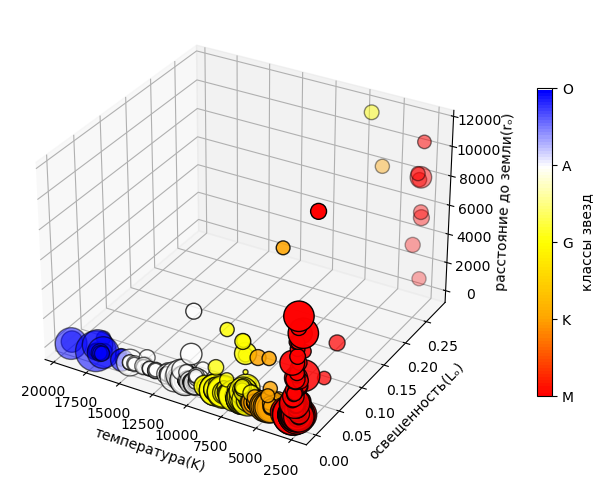

In [26]:
fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot(111, projection='3d')
k = 3000

yP = Luminosity_DecisionTree[0][:k]
xP = Temperature_DecisionTree[0][:k]
zP = distance_RandomForest[0][:k]
size = dfm['Radius(R/Ro)'][:k] * 1000

colors = ['red','orange','yellow','white', 'blue']
n_bins = 100
cmap_name = 'starClasses'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N= n_bins)

everycolor = []
for j in range(len(Temperature_DecisionTree[0])):
    if Temperature_DecisionTree[0][j] <= 4500 :
        everycolor.append(("#ff0000"))
    if Temperature_DecisionTree[0][j] >= 4501 and Temperature_DecisionTree[0][j] <= 6000:
        everycolor.append(("#ffa500"))
    if Temperature_DecisionTree[0][j] >= 6001 and Temperature_DecisionTree[0][j] <= 10000:
        everycolor.append(("#ffff00"))
    if Temperature_DecisionTree[0][j] >= 10001 and Temperature_DecisionTree[0][j] <= 15000:
        everycolor.append(("#ffffff"))
    if Temperature_DecisionTree[0][j] >= 15001:
        everycolor.append(("#0000ff"))

ax2.scatter(xP,yP,zP,sizes = size, c = everycolor[:k], marker = 'o',edgecolor = 'black', s = 100)

ax2.set_xlabel("температура(K)")
ax2.set_ylabel("освещенность(Lₒ)")
ax2.set_zlabel("расстояние до земли(rₒ)")
plt.gca().invert_xaxis()


Z = [i for i in range(160)]
sm = ScalarMappable(cmap= cm, norm=Normalize(vmin=np.min(Z), vmax=np.max(Z)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, pad=0.1, shrink = 0.5)

cbar.set_ticks([0,40,80,120,160])
cbar.set_ticklabels(['M','K','G','A','O'])

cbar.set_label('классы звезд')
plt.show()

и получим 2D срез, чтобы сравнить с оригиналом

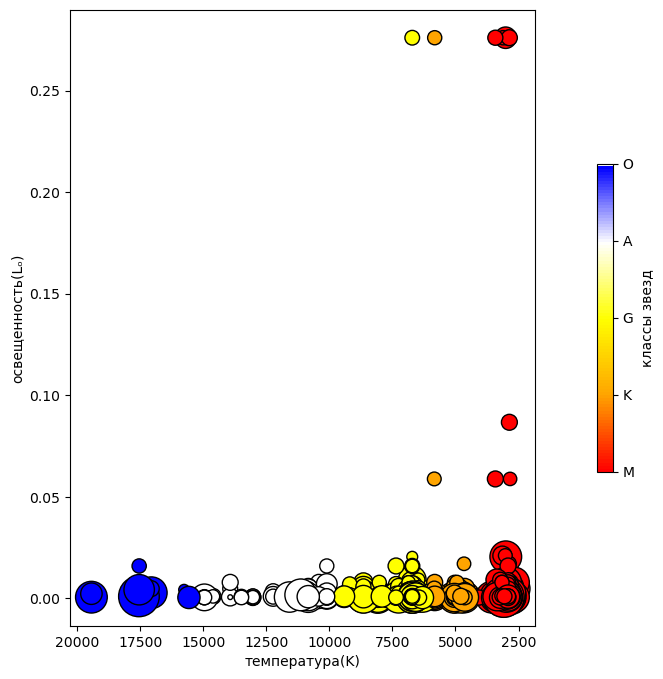

In [27]:
fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot()
k = 3000

yP = Luminosity_DecisionTree[0][:k]
xP = Temperature_DecisionTree[0][:k]
size = dfm['Radius(R/Ro)'][:k] * 1000

colors = ['red','orange','yellow','white', 'blue']
n_bins = 100
cmap_name = 'starClasses'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N= n_bins)

everycolor = []
for j in range(len(Temperature_DecisionTree[0])):
    if Temperature_DecisionTree[0][j] <= 4500 :
        everycolor.append(("#ff0000"))
    if Temperature_DecisionTree[0][j] >= 4501 and Temperature_DecisionTree[0][j] <= 6000:
        everycolor.append(("#ffa500"))
    if Temperature_DecisionTree[0][j] >= 6001 and Temperature_DecisionTree[0][j] <= 10000:
        everycolor.append(("#ffff00"))
    if Temperature_DecisionTree[0][j] >= 10001 and Temperature_DecisionTree[0][j] <= 15000:
        everycolor.append(("#ffffff"))
    if Temperature_DecisionTree[0][j] >= 15001:
        everycolor.append(("#0000ff"))

ax2.scatter(xP,yP,sizes = size, c = everycolor[:k], marker = 'o',edgecolor = 'black', s = 100)

ax2.set_xlabel("температура(K)")
ax2.set_ylabel("освещенность(Lₒ)")
plt.gca().invert_xaxis()


Z = [i for i in range(160)]
sm = ScalarMappable(cmap= cm, norm=Normalize(vmin=np.min(Z), vmax=np.max(Z)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, pad=0.1, shrink = 0.5)

cbar.set_ticks([0,40,80,120,160])
cbar.set_ticklabels(['M','K','G','A','O'])
cbar.set_label('классы звезд')
plt.show()

При рассмотрении графика видно, что если бы мы обладали теми данными, которые 
используются в оригинальной диаграмме, то была бы получена копия, то есть это говорит 
о том, что соблюдена правильность построения и пропорции. Таким образом, получилось заполнить “пробел”, который выражался в нехватке данных 
при нахождении n-ной переменной, сверяя выводы с задачами, можно утверждать, что 
проект по исследованию методов машинного обучения в астрономии и построению 
расширенной диаграммы Герцшпрунга-Рассела успешно завершен